In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv("SeoulBikeDataClean.csv")

# Time-based train/val/test split
train_df = df[df['datetime'] < '2018-10-01']
val_df   = df[(df['datetime'] >= '2018-10-01') & (df['datetime'] < '2018-11-01')]
test_df  = df[df['datetime'] >= '2018-11-01']

print("Train:", train_df.shape)
print("Val:  ", val_df.shape)
print("Test: ", test_df.shape)

Train: (6984, 40)
Val:   (665, 40)
Test:  (648, 40)


## OLS regression with full features

In [3]:
features = ['temperaturec', 'humiditypct',
       'wind_speed_m_s', 'visibility_10m', 'dew_point_temperaturec',
       'solar_radiation_mj_m2', 'Autumn',
       'Spring', 'Summer', 'Winter', 'phase0to6', 'phase7to9', 'phase10to17', 'phase18to19', 'phase20to24', 'is_raining',
       'is_snowing', 'temperaturec_squared', 'is_weekend', 'is_holiday',
       'is_working_day', 'temp_rain', 'temp_snow', 'humid_rain', 'lag_1',
       'lag_24', 'rolling_24_mean', 'rolling_168_mean']

train_X = train_df[features]
train_y = train_df['rented_bike_count']

model = sm.OLS(train_y,train_X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      rented_bike_count   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     1955.
Date:                Mon, 12 May 2025   Prob (F-statistic):               0.00
Time:                        14:50:23   Log-Likelihood:                -47962.
No. Observations:                6984   AIC:                         9.598e+04
Df Residuals:                    6958   BIC:                         9.615e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
temperaturec               5

In [4]:
test_X = test_df[features]
test_y = test_df['rented_bike_count']

y_pred = results.predict(test_X)

rmse = mean_squared_error(test_y, y_pred, squared=False)
r2 = r2_score(test_y, y_pred)

print(f" Test RMSE: {rmse:.2f}")
print(f" Test R²:   {r2:.4f}")

 Test RMSE: 226.00
 Test R²:   0.7538


## Multicolinearity check: VIF

In [5]:
# calculate Variance Inflation Factor for each explanatory variable
from statsmodels.stats.outliers_influence import variance_inflation_factor

# The dataframe passed to VIF must include the intercept term. We add it the same way we did before.
def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

cols = ['temperaturec', 'humiditypct', 'wind_speed_m_s', 'visibility_10m', 'dew_point_temperaturec', 'solar_radiation_mj_m2', 'temperaturec_squared', 'temp_rain', 'temp_snow',
       'humid_rain', 'lag_1', 'lag_24', 'rolling_24_mean', 'rolling_168_mean']
VIF(train_X, cols)

temperaturec               99.120170
humiditypct                21.157389
wind_speed_m_s              1.317707
visibility_10m              1.729969
dew_point_temperaturec    130.274141
solar_radiation_mj_m2       2.136081
temperaturec_squared        7.110657
temp_rain                   5.284902
temp_snow                   1.437428
humid_rain                  5.723768
lag_1                       2.737499
lag_24                      2.458665
rolling_24_mean             6.205079
rolling_168_mean            7.766011
dtype: float64

### Drop feature `dew_point_temperaturec`

In [6]:
features_1 = ['temperaturec', 'humiditypct',
       'wind_speed_m_s', 'visibility_10m',
       'solar_radiation_mj_m2', 'Autumn',
       'Spring', 'Summer', 'Winter', 'phase0to6', 'phase7to9', 'phase10to17', 'phase18to19', 'phase20to24', 'is_raining',
       'is_snowing', 'temperaturec_squared', 'is_weekend', 'is_holiday',
       'is_working_day', 'temp_rain', 'temp_snow', 'humid_rain', 'lag_1',
       'lag_24', 'rolling_24_mean', 'rolling_168_mean']

train_X_1 = train_df[features_1]

model_1 = sm.OLS(train_y,train_X_1)
results_1 = model_1.fit()


test_X_1 = test_df[features_1]

y_pred_1 = results_1.predict(test_X_1)

rmse = mean_squared_error(test_y, y_pred_1, squared=False)
r2 = r2_score(test_y, y_pred_1)

print(f" Test RMSE: {rmse:.2f}")
print(f" Test R²:   {r2:.4f}")

 Test RMSE: 225.96
 Test R²:   0.7539


In [7]:
cols = ['temperaturec', 'humiditypct', 'wind_speed_m_s', 'visibility_10m', 'solar_radiation_mj_m2', 'temperaturec_squared', 'temp_rain', 'temp_snow',
       'humid_rain', 'lag_1', 'lag_24', 'rolling_24_mean', 'rolling_168_mean']
VIF(train_X, cols)

temperaturec             13.578869
humiditypct               3.070901
wind_speed_m_s            1.316944
visibility_10m            1.729325
solar_radiation_mj_m2     2.033401
temperaturec_squared      6.952476
temp_rain                 5.256278
temp_snow                 1.436237
humid_rain                5.604520
lag_1                     2.737393
lag_24                    2.440318
rolling_24_mean           6.155071
rolling_168_mean          7.752225
dtype: float64

### Drop feature `temperaturec`

In [8]:
features_2 = ['humiditypct',
       'wind_speed_m_s', 'visibility_10m',
       'solar_radiation_mj_m2', 'Autumn',
       'Spring', 'Summer', 'Winter', 'phase0to6', 'phase7to9', 'phase10to17', 'phase18to19', 'phase20to24', 'is_raining',
       'is_snowing', 'temperaturec_squared', 'is_weekend', 'is_holiday',
       'is_working_day', 'temp_rain', 'temp_snow', 'humid_rain', 'lag_1',
       'lag_24', 'rolling_24_mean', 'rolling_168_mean']

train_X_2 = train_df[features_2]

model_2 = sm.OLS(train_y,train_X_2)
results_2 = model_2.fit()


test_X_2 = test_df[features_2]

y_pred_2 = results_2.predict(test_X_2)

rmse = mean_squared_error(test_y, y_pred_2, squared=False)
r2 = r2_score(test_y, y_pred_2)

print(f" Test RMSE: {rmse:.2f}")
print(f" Test R²:   {r2:.4f}")

 Test RMSE: 227.99
 Test R²:   0.7494


In [9]:
cols = ['humiditypct', 'wind_speed_m_s', 'visibility_10m', 'solar_radiation_mj_m2', 'temperaturec_squared', 'temp_rain', 'temp_snow',
       'humid_rain', 'lag_1', 'lag_24', 'rolling_24_mean', 'rolling_168_mean']
VIF(train_X, cols)

humiditypct              2.931325
wind_speed_m_s           1.316521
visibility_10m           1.710021
solar_radiation_mj_m2    1.921699
temperaturec_squared     2.625440
temp_rain                5.238473
temp_snow                1.091677
humid_rain               5.604516
lag_1                    2.619331
lag_24                   2.437777
rolling_24_mean          5.960508
rolling_168_mean         7.132479
dtype: float64

In [10]:
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:      rented_bike_count   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     2118.
Date:                Mon, 12 May 2025   Prob (F-statistic):               0.00
Time:                        14:50:23   Log-Likelihood:                -47973.
No. Observations:                6984   AIC:                         9.599e+04
Df Residuals:                    6960   BIC:                         9.616e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
humiditypct              -1.04

### Drop features with p-value too large: `wind_speed_m_s`, `humid_rain`, `visibility_10m`

In [11]:
features_3 = ['humiditypct',
       'solar_radiation_mj_m2', 'Autumn',
       'Spring', 'Summer', 'Winter', 'phase0to6', 'phase7to9', 'phase10to17', 'phase18to19', 'phase20to24', 'is_raining',
       'is_snowing', 'temperaturec_squared', 'is_weekend', 'is_holiday',
       'is_working_day', 'temp_rain', 'temp_snow', 'lag_1',
       'lag_24', 'rolling_24_mean', 'rolling_168_mean']

train_X_3 = train_df[features_3]

model_3 = sm.OLS(train_y,train_X_3)
results_3 = model_3.fit()
print(results_3.summary())

test_X_3 = test_df[features_3]

y_pred_3 = results_3.predict(test_X_3)

rmse = mean_squared_error(test_y, y_pred_3, squared=False)
r2 = r2_score(test_y, y_pred_3)

print(f" Test RMSE: {rmse:.2f}")
print(f" Test R²:   {r2:.4f}")

                            OLS Regression Results                            
Dep. Variable:      rented_bike_count   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     2436.
Date:                Mon, 12 May 2025   Prob (F-statistic):               0.00
Time:                        14:50:23   Log-Likelihood:                -47974.
No. Observations:                6984   AIC:                         9.599e+04
Df Residuals:                    6963   BIC:                         9.613e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
humiditypct              -1.26

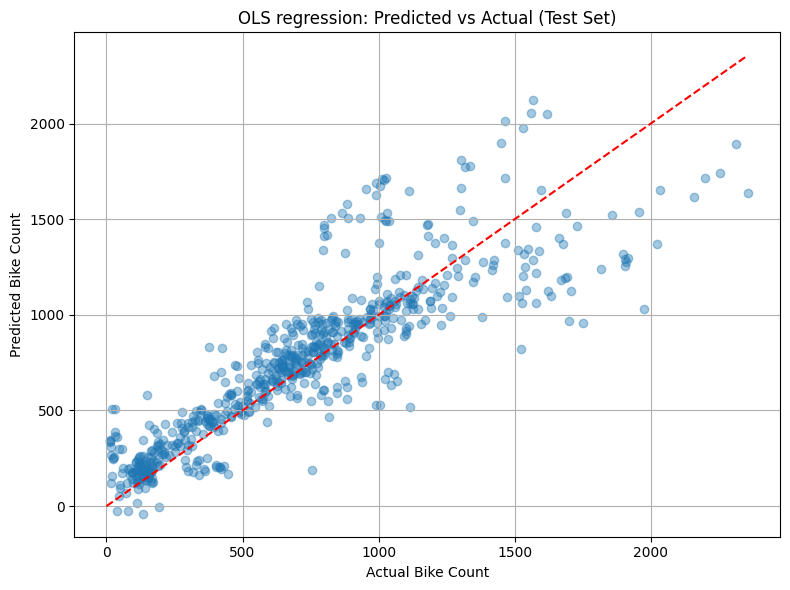

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(test_y, y_pred_3, alpha=0.4)
plt.plot([0, max(test_y)], [0, max(test_y)], 'r--')
plt.xlabel("Actual Bike Count")
plt.ylabel("Predicted Bike Count")
plt.title("OLS regression: Predicted vs Actual (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Check Heteroscedasticity

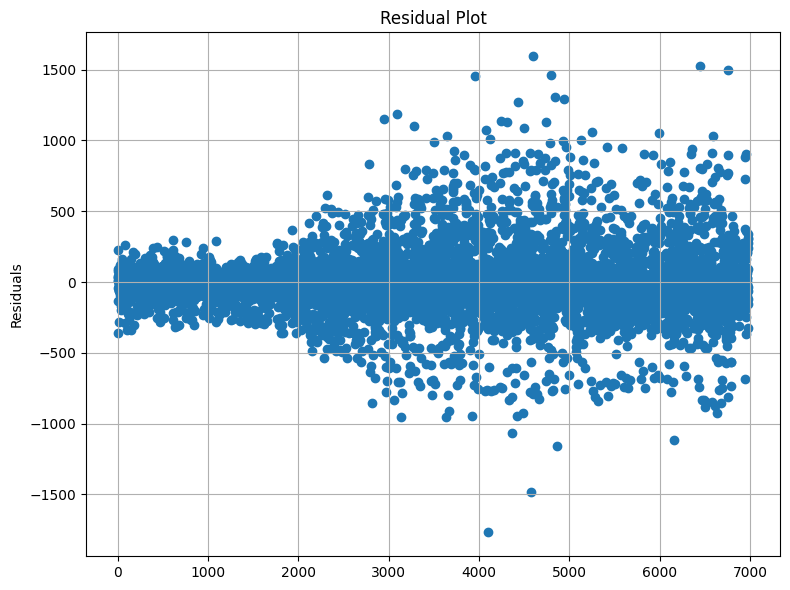

In [13]:
residuals = results_3.resid
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(residuals)), residuals)
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(residuals, sm.add_constant(train_X_3))
print(f"Breusch-Pagan stats: {bp_test[0]:.3f}, p-value: {bp_test[1]:.3f}")

Breusch-Pagan stats: 1905.351, p-value: 0.000


In [15]:
robust_results = model_3.fit(cov_type='HC3')
print(robust_results.summary())

y_pred_robust = robust_results.predict(test_X_3)
rmse = mean_squared_error(test_y, y_pred_robust, squared=False)
r2 = r2_score(test_y, y_pred_robust)

print(f" Test RMSE: {rmse:.2f}")
print(f" Test R²:   {r2:.4f}")

                            OLS Regression Results                            
Dep. Variable:      rented_bike_count   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 12 May 2025   Prob (F-statistic):                nan
Time:                        14:50:24   Log-Likelihood:                -47974.
No. Observations:                6984   AIC:                         9.599e+04
Df Residuals:                    6963   BIC:                         9.613e+04
Df Model:                          20                                         
Covariance Type:                  HC3                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
humiditypct              -1.26